<a href="https://colab.research.google.com/github/horaja/PointCloudAutoEncoder/blob/main/PointCloud_Autoencoder_Official_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
The following few codeblocks are for imported files
```

In [9]:
# Dataloaders.py

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import os

class ReadDataset(Dataset):
    def __init__(self,  source):

        self.data = torch.from_numpy(source).float()


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

def RandomSplit(datasets, train_set_percentage):
    lengths = [int(len(datasets)*train_set_percentage), len(datasets)-int(len(datasets)*train_set_percentage)]
    return random_split(datasets, lengths)

def GetDataLoaders(npArray, batch_size, train_set_percentage = 0.7, shuffle=True, num_workers=0, pin_memory=True):


    pc = ReadDataset(npArray)

    train_set, test_set = RandomSplit(pc, train_set_percentage)

    train_loader = DataLoader(train_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)
    test_loader = DataLoader(test_set, shuffle=shuffle, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

    return train_loader, test_loader

def CondensePointClouds(input_folder, expected_num_points, x_range=(0,10), y_range=(-5,5), z_range=(-5,1)):
    all_point_clouds = []

    for filename in os.listdir(input_folder):
        if filename.endswith(".npz"):
            file_path = os.path.join(input_folder, filename)
            data = np.load(file_path)

            point_cloud = data['points']

            mask = (
                (point_cloud[:, 0] >= x_range[0]) & (point_cloud[:, 0] <= x_range[1]) &
                (point_cloud[:, 1] >= y_range[0]) & (point_cloud[:, 1] <= y_range[1]) &
                (point_cloud[:, 2] >= z_range[0]) & (point_cloud[:, 2] <= z_range[1])
            )

            filtered_points = point_cloud[mask]

            if len(filtered_points) > expected_num_points:
                sampled_indices = np.random.choice(len(filtered_points), expected_num_points, replace=False)
                sampled_points = filtered_points[sampled_indices]
            else:
                print("Padding required - may need to modify expected num points")
                padding_shape = (expected_num_points - len(filtered_points), 3)
                sampled_points = np.pad(filtered_points, ((0, padding_shape[0]), (0,0)), 'constant', constant_values=0)

            all_point_clouds.append(sampled_points)

    combined_data = np.stack(all_point_clouds, axis=0)

    return combined_data

In [10]:
# Model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

'''
PointNet AutoEncoder
Learning Representations and Generative Models For 3D Point Clouds
https://arxiv.org/abs/1707.02392
'''

class PointCloudAE(nn.Module):
    def __init__(self, point_size, latent_size):
        super(PointCloudAE, self).__init__()

        self.latent_size = latent_size
        self.point_size = point_size

        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, self.latent_size, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(self.latent_size)

        self.dec1 = nn.Linear(self.latent_size,256)
        self.dec2 = nn.Linear(256,256)
        self.dec3 = nn.Linear(256,self.point_size*3)

    def encoder(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, self.latent_size)
        return x

    def decoder(self, x):
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = self.dec3(x)
        return x.view(-1, self.point_size, 3)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [11]:
# utils.py

import matplotlib.pyplot as plt
import os
import shutil

def clear_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
    os.mkdir(path)


def plotPCbatch(pcArray1, pcArray2, show = True, save = False, name=None, fig_count=9 , sizex = 12, sizey=3):

    pc1 = pcArray1[0:fig_count]
    pc2 = pcArray2[0:fig_count]

    fig=plt.figure(figsize=(sizex, sizey))

    for i in range(fig_count*2):

        ax = fig.add_subplot(2,fig_count,i+1, projection='3d')

        if(i<fig_count):
            ax.scatter(pc1[i,:,0], pc1[i,:,2], pc1[i,:,1], c='b', marker='.', alpha=0.8, s=8)
        else:
            ax.scatter(pc2[i-fig_count,:,0], pc2[i-fig_count,:,2], pc2[i-fig_count,:,1], c='b', marker='.', alpha=0.8, s=8)

        ax.set_xlim3d(0.25, 0.75)
        ax.set_ylim3d(0.25, 0.75)
        ax.set_zlim3d(0.25, 0.75)

        plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)

    if(save):
        fig.savefig(name + '.png')
        plt.close(fig)

    if(show):
        plt.show()
    else:
        return fig

def visualise_3(true_points, output_file=None):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim([0, 40])
    ax.set_ylim([-20, 20])
    ax.set_zlim([-15, 15])
    ax.scatter(true_points[:, 0], true_points[:, 1], true_points[:, 2], s=1)

    if (output_file):
        fig.savefig(output_file)

    plt.show()



```
The following codeblock is for library imports.
```



In [12]:
# No need to import because manually added to colab file
# import Dataloaders
# import utils
# import model

import torch
import time
import matplotlib.pyplot as plt

```
Next, we must configure necessary parameters:
 - batch size
 - name of output folder to save results
 - save results enable/disable flag
 - GPU acceleration flag
 - dimension of compressed representation
```

In [23]:
batch_size = 32
output_folder = "output/"
save_results = False
use_GPU = True
latent_size = 128

if(save_results):
    utils.clear_folder(output_folder)

```
Next, we must load in our data properly

We must also condense thousands of pointcloud snapshots into one file.

Factors to influence:
 - # of snapshots
 - # of points per snapshot
 - area to extract points for each snapshot (ranges)
```

In [15]:
input_folder = "/content/input_data"

combined_data = CondensePointClouds(input_folder, 1024)
pc_array = combined_data
print(pc_array.shape) # for testing purposes

train_loader, test_loader = GetDataLoaders(npArray=pc_array, batch_size=batch_size)
print(f"Train dataset size: {len(train_loader.dataset)}") # for testing purposes
print(f"Test dataset size: {len(test_loader.dataset)}") # for testing purposes
print(f"Batch size: {batch_size}") # for testing purposes

point_size = len(train_loader.dataset[0])

(301, 1024, 3)
Train dataset size: 210
Test dataset size: 91
Batch size: 32


```
Model Setup
```

In [17]:
net = PointCloudAE(point_size,latent_size)

if(use_GPU):
    device = torch.device("cuda:0")
    if torch.cuda.device_count() > 1: # if there are multiple GPUs use all
        net = torch.nn.DataParallel(net)
else:
    device = torch.device("cpu")

```
Import and initialize loss (chamfer distance)
Define an optimizer
```

In [18]:
!pip install chamferdist
from chamferdist import ChamferDistance
chamfer_distance = ChamferDistance()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

  Preparing metadata (setup.py) ... done
  Created wheel for chamferdist: filename=chamferdist-1.0.3-cp311-cp311-linux_x86_64.whl size=6513839 sha256=0c2fc3213ae055108f25fcb2a085448125da8987d92df4fb08b9fbc332adead6
  Stored in directory: /root/.cache/pip/wheels/11/ff/f8/c0404e5cb99e229be6b55f50cbdbc1cdebf7b74dbc39edb622
Successfully built chamferdist


```
Next, we must define training and testing functions
```

In [19]:
def train_epoch():
    epoch_loss = 0
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data.permute(0,2,1))
        loss = chamfer_distance(data, output)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss/i

In [20]:
def test_batch(data):
    with torch.no_grad():
        output = net(data.permute(0,2,1))
        loss = chamfer_distance(data, output)

    return loss.item(), output.cpu()

In [21]:
def test_epoch():
    with torch.no_grad():
        epoch_loss = 0
        for i, data in enumerate(test_loader):
            loss, output = test_batch(data)
            epoch_loss += loss

    if i != 0:
      return epoch_loss/i
    return epoch_loss

```
Training Loop

Be sure to edit the number of epochs!
```

epoch 0 train loss : 1977.4283650716145 test loss : 1033.6297607421875 epoch time : 4.476444482803345



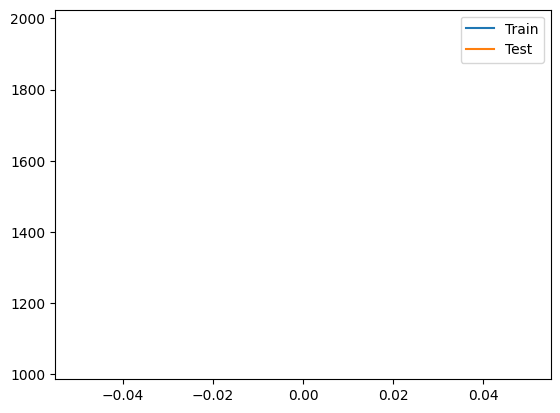

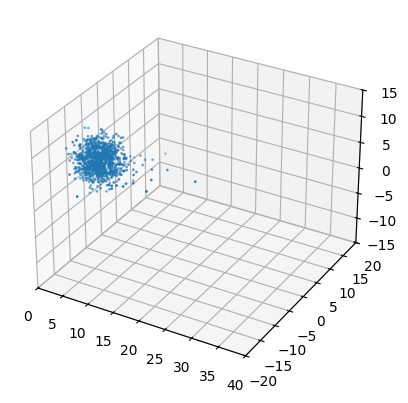

epoch 1 train loss : 570.8860219319662 test loss : 477.2908630371094 epoch time : 3.354691505432129



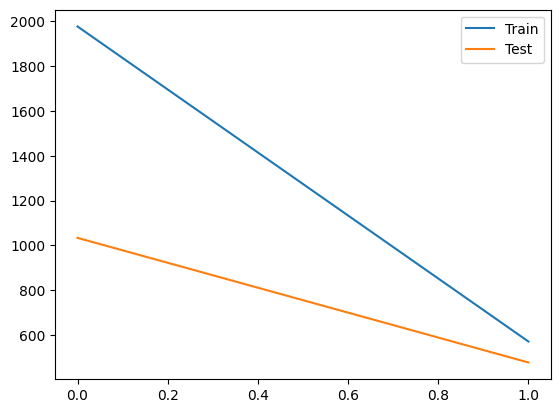

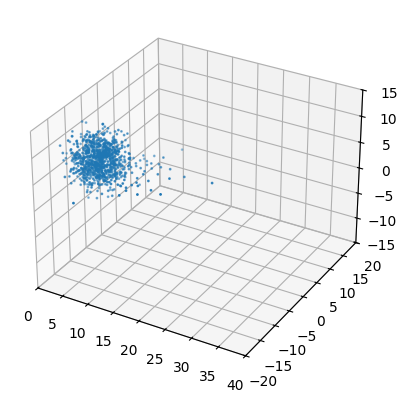

epoch 2 train loss : 309.2781575520833 test loss : 318.08495330810547 epoch time : 3.4193267822265625



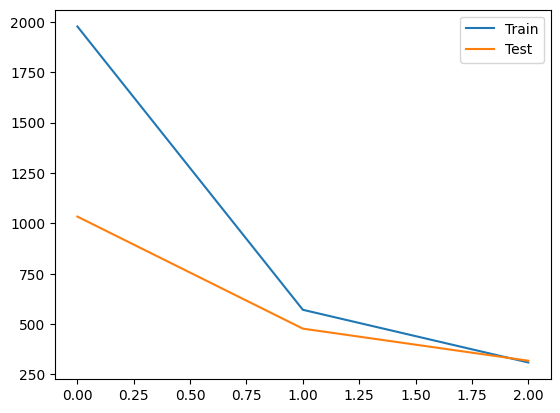

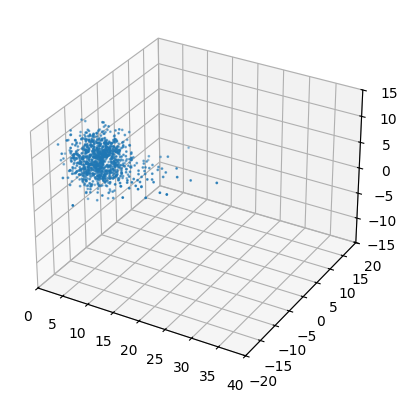

epoch 3 train loss : 226.48580932617188 test loss : 263.4804916381836 epoch time : 4.20517110824585



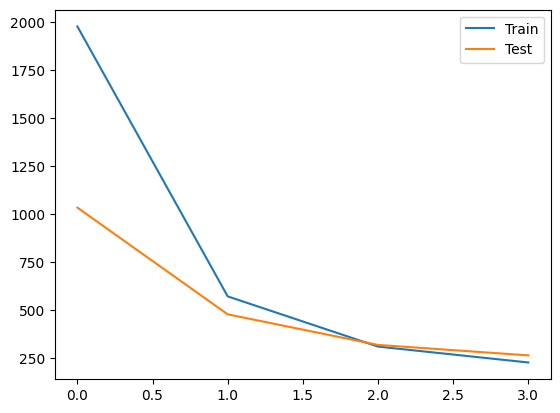

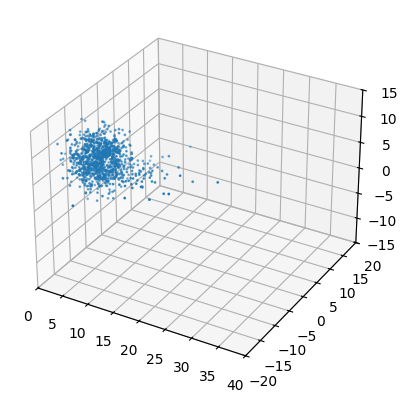

epoch 4 train loss : 188.4021250406901 test loss : 217.64022064208984 epoch time : 3.4388113021850586



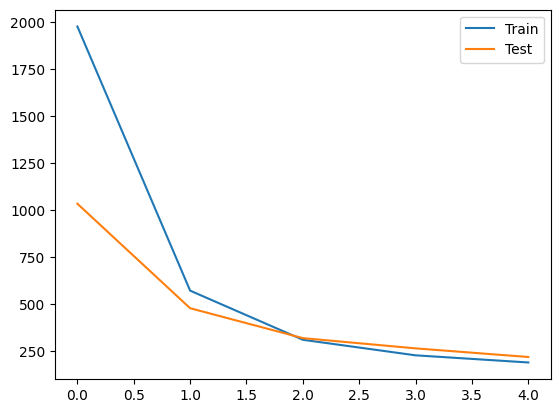

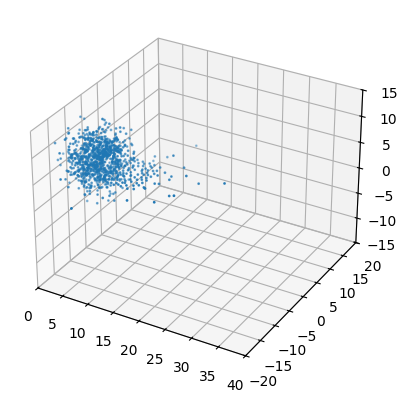

epoch 5 train loss : 164.7584025065104 test loss : 202.751708984375 epoch time : 3.4151313304901123



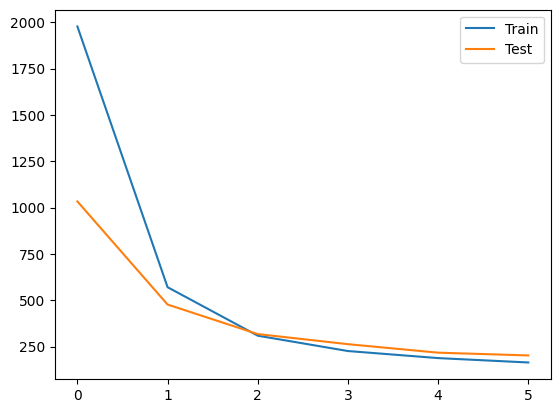

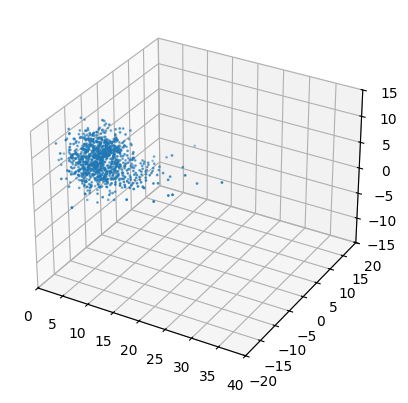

epoch 6 train loss : 153.87466176350912 test loss : 189.72157669067383 epoch time : 4.251141309738159



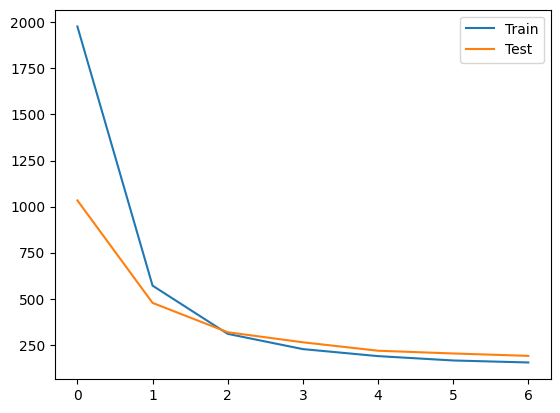

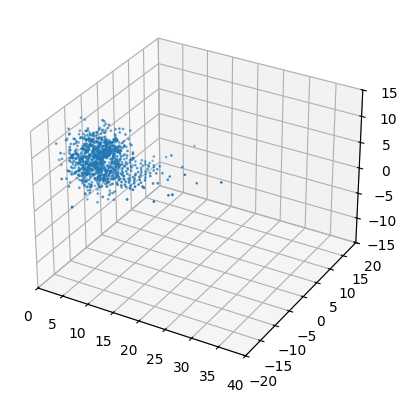

epoch 7 train loss : 144.96689732869467 test loss : 178.22646713256836 epoch time : 3.3930273056030273



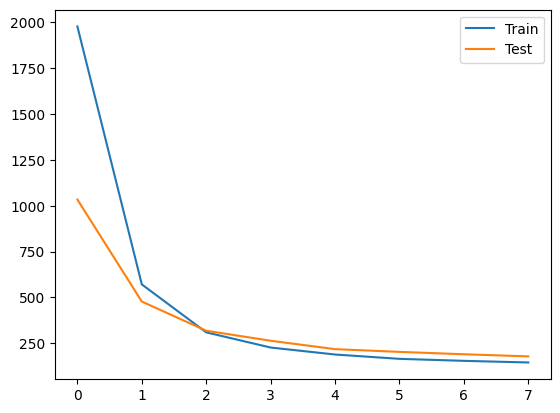

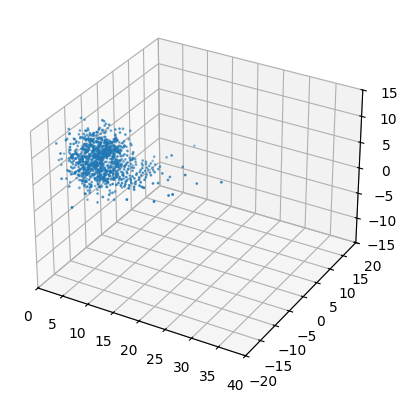

epoch 8 train loss : 138.58401234944662 test loss : 173.67718887329102 epoch time : 3.6149520874023438



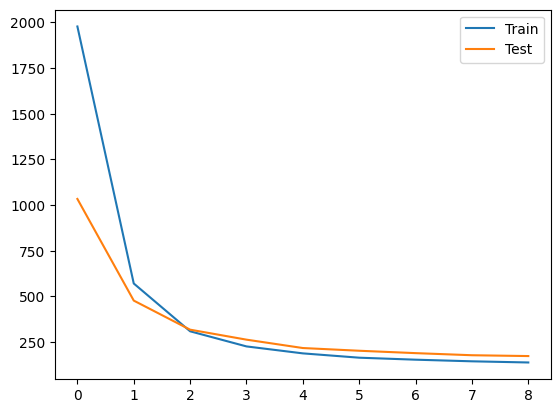

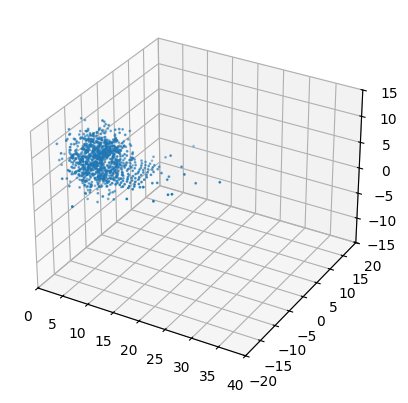

epoch 9 train loss : 134.85955301920572 test loss : 168.7448387145996 epoch time : 4.178314685821533



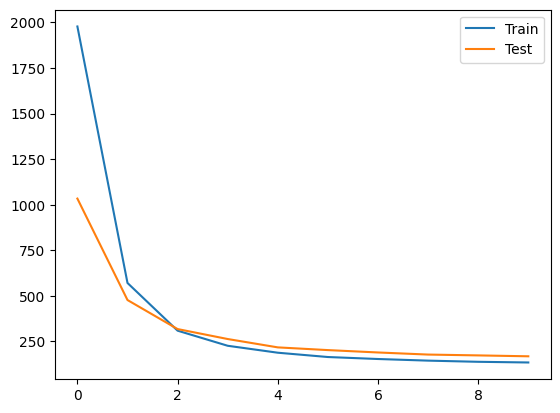

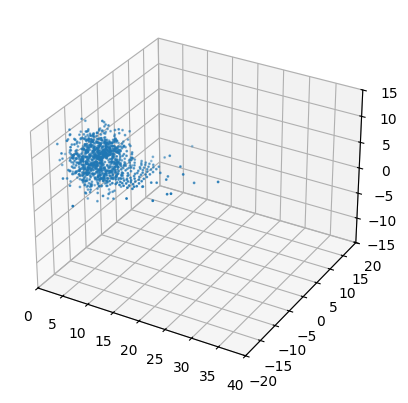

In [25]:
train_loss_list = []
test_loss_list = []

for i in range(10) :

    startTime = time.time()
    train_loss = train_epoch()
    train_loss_list.append(train_loss)

    test_loss = test_epoch()
    test_loss_list.append(test_loss)

    epoch_time = time.time() - startTime

    writeString = "epoch " + str(i) + " train loss : " + str(train_loss) + " test loss : " + str(test_loss) + " epoch time : " + str(epoch_time) + "\n"

    plt.plot(train_loss_list, label="Train")
    plt.plot(test_loss_list, label="Test")
    plt.legend()

    if (save_results):
        with open(output_folder + "prints.txt","a") as file:
            file.write(writeString)

        plt.savefig(output_folder + "loss.png")
        plt.close()

        # FIX: save all these to output folder, not just show them.
        if(i%50==0):
            test_samples = next(iter(test_loader))
            loss , test_output = test_batch(test_samples)
            visualise_3(test_output[i], output_file= (output_folder  + "epoch_" + str(i)))

    else:
        print(writeString)
        test_samples = next(iter(test_loader))
        loss , test_output = test_batch(test_samples)
        index = i % len(test_output)
        visualise_3(test_output[index])
        plt.show()
